## Financial News Sentiment Analysis and Stock Performance Correlation

### Objective is to analyze the sentiment of fiancial news articles using NLP and comparing the sentiment trends to stock market performance

Step 1: Collecting financial news article data via NewsAPI 

In [1]:
import requests
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import yfinance as yf
# Set your API key
api_key = 'b07683d4fbed401490f767a345aebfdb'

# Define the date range
end_date = datetime.now()
start_date = end_date - timedelta(days=60)  # Extended to 60 days

# Fetch news articles in smaller chunks to ensure broader coverage
articles_list = []

for i in range(60):  # Adjusted for 60 days
    chunk_start_date = start_date + timedelta(days=i)
    chunk_end_date = chunk_start_date + timedelta(days=1)
    
    url = (f'https://newsapi.org/v2/everything?q=stock market&from={chunk_start_date.strftime("%Y-%m-%d")}'
           f'&to={chunk_end_date.strftime("%Y-%m-%d")}&language=en&sortBy=publishedAt&apiKey={api_key}')
    response = requests.get(url)
    
    if response.status_code == 200:
        articles = response.json().get('articles', [])
        articles_list.extend(articles)
    else:
        print(f"Error fetching data: {response.status_code}")

# Store the articles in a pandas df
df = pd.DataFrame(articles_list)
print(df[['publishedAt', 'title', 'description']])


Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 426
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429
Error fetching data: 429


Step 2: Employ NLTK's VADER sentiment analysis tool to assess the news article and calculate daily/weekly averages

What is VADER? It means Valence Aware Dictionary and sEntiment Reasoner, it's a lexicon and rule-based feeling analysis instrument that is explicitally sensitive to words and opinions in web-basd media. It uses a mix of words and other lexical highlghts to determine a polarity score.

In [2]:
# Phase 2: Pre-processing & Sentiment Analysis
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Function to get the sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound'] if text else 0

df['sentiment'] = df['description'].apply(get_sentiment_score)

# Convert 'publishedAt' to datetime and ensure dates are parsed correctly
df['publishedAt'] = pd.to_datetime(df['publishedAt']).dt.date

# Filter out invalid dates if necessary
df = df[df['publishedAt'] >= datetime(2024, 4, 26).date()]

# Group by day and calculate average sentiment
df['day'] = df['publishedAt']
daily_sentiment = df.groupby('day')['sentiment'].mean().reset_index()

# Group by week and calculate average sentiment
df['week'] = pd.to_datetime(df['day']).dt.to_period('W').apply(lambda r: r.start_time)
weekly_sentiment = df.groupby('week')['sentiment'].mean().reset_index()

# Display the daily and weekly sentiment
print(daily_sentiment.head(10))
print(weekly_sentiment.head(10))

# Display the range of dates
print(f"Date range: {df['day'].min()} to {df['day'].max()}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


          day  sentiment
0  2024-05-28   0.224182
1  2024-05-29   0.159129
2  2024-05-30   0.208097
3  2024-05-31   0.163016
4  2024-06-01   0.381046
5  2024-06-02   0.277242
6  2024-06-03   0.176079
7  2024-06-04   0.230462
8  2024-06-05   0.273600
9  2024-06-06   0.113385
        week  sentiment
0 2024-05-27   0.234595
1 2024-06-03   0.206588
Date range: 2024-05-28 to 2024-06-07


In [3]:
#print the first element of the df here 
print(df.head(1))

                                       source author  \
0  {'id': None, 'name': 'Marketscreener.com'}   None   

                                               title  \
0  Okumura : THE 87TH ANNUAL GENERAL MEETING OF S...   

                                         description  \
0  (marketscreener.com) \n \n Note: This document...   

                                                 url  \
0  https://www.marketscreener.com/quote/stock/OKU...   

                                          urlToImage publishedAt  \
0  https://www.marketscreener.com/images/twitter_...  2024-05-28   

                                             content  sentiment         day  \
0  Note: This document has been translated from t...     0.7096  2024-05-28   

        week  
0 2024-05-27  


Step 3: Data preprocessing

Cleaned and preprocessed the data to ensure the date alignment, and merged the sentiment data with the stock price data based on dates

In [4]:
# Fetching stock market data for daily trends

# Define the stock ticker and date range
ticker = 'SPY'  # S&P 500 ETF as an example
end_date = datetime.now().date()
start_date = end_date - timedelta(days=90)  # Extended to 90 days
stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Calculate daily returns
stock_data['daily_return'] = stock_data['Adj Close'].pct_change()

# Reset the index to join with sentiment data
stock_data.reset_index(inplace=True)

# Convert Date to date
stock_data['Date'] = stock_data['Date'].dt.date

# Display the stock data
print("Stock Data with Daily Returns:\n", stock_data[['Date', 'daily_return']])


[*********************100%%**********************]  1 of 1 completed

Stock Data with Daily Returns:
           Date  daily_return
0   2024-04-01           NaN
1   2024-04-02     -0.006358
2   2024-04-03      0.001099
3   2024-04-04     -0.012206
4   2024-04-05      0.010447
..         ...           ...
56  2024-06-20     -0.002717
57  2024-06-21     -0.001341
58  2024-06-24     -0.003251
59  2024-06-25      0.003851
60  2024-06-26      0.001248

[61 rows x 2 columns]


Step 4: Correlation Analysis

Calculated the correlation between daily sentiment scores and daily stock returns.

In [5]:
# Verify the date ranges in daily_sentiment again after filtering
print("Filtered Daily Sentiment Dates:\n", daily_sentiment['day'].unique())

# Verify the date ranges in stock_data
print("Stock Data Dates:\n", stock_data['Date'].unique())

# Merging daily sentiment and stock data after filtering invalid dates
daily_combined_data = pd.merge(daily_sentiment, stock_data[['Date', 'daily_return']], left_on='day', right_on='Date', how='inner')

# Display the daily combined data
print("Daily Combined Data:\n", daily_combined_data.head(10))

# Handle missing data
daily_combined_data.dropna(subset=['daily_return'], inplace=True)

# Display the daily combined data after dropping NaNs
print("Daily Combined Data After Dropping NaNs:\n", daily_combined_data[['day', 'sentiment', 'daily_return']].head(10))

# Calculate daily correlation if there are enough data points
if len(daily_combined_data) > 1:
    daily_correlation = daily_combined_data['sentiment'].corr(daily_combined_data['daily_return'])
    print(f'Correlation between daily sentiment and daily stock performance: {daily_correlation}')
else:
    print("Not enough data points to calculate daily correlation.")


Filtered Daily Sentiment Dates:
 [datetime.date(2024, 5, 28) datetime.date(2024, 5, 29)
 datetime.date(2024, 5, 30) datetime.date(2024, 5, 31)
 datetime.date(2024, 6, 1) datetime.date(2024, 6, 2)
 datetime.date(2024, 6, 3) datetime.date(2024, 6, 4)
 datetime.date(2024, 6, 5) datetime.date(2024, 6, 6)
 datetime.date(2024, 6, 7)]
Stock Data Dates:
 [datetime.date(2024, 4, 1) datetime.date(2024, 4, 2)
 datetime.date(2024, 4, 3) datetime.date(2024, 4, 4)
 datetime.date(2024, 4, 5) datetime.date(2024, 4, 8)
 datetime.date(2024, 4, 9) datetime.date(2024, 4, 10)
 datetime.date(2024, 4, 11) datetime.date(2024, 4, 12)
 datetime.date(2024, 4, 15) datetime.date(2024, 4, 16)
 datetime.date(2024, 4, 17) datetime.date(2024, 4, 18)
 datetime.date(2024, 4, 19) datetime.date(2024, 4, 22)
 datetime.date(2024, 4, 23) datetime.date(2024, 4, 24)
 datetime.date(2024, 4, 25) datetime.date(2024, 4, 26)
 datetime.date(2024, 4, 29) datetime.date(2024, 4, 30)
 datetime.date(2024, 5, 1) datetime.date(2024, 5, 2)


##### Visualizing the results (i.e. sentiment over time, stock performance over time, correlation scatterplot)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

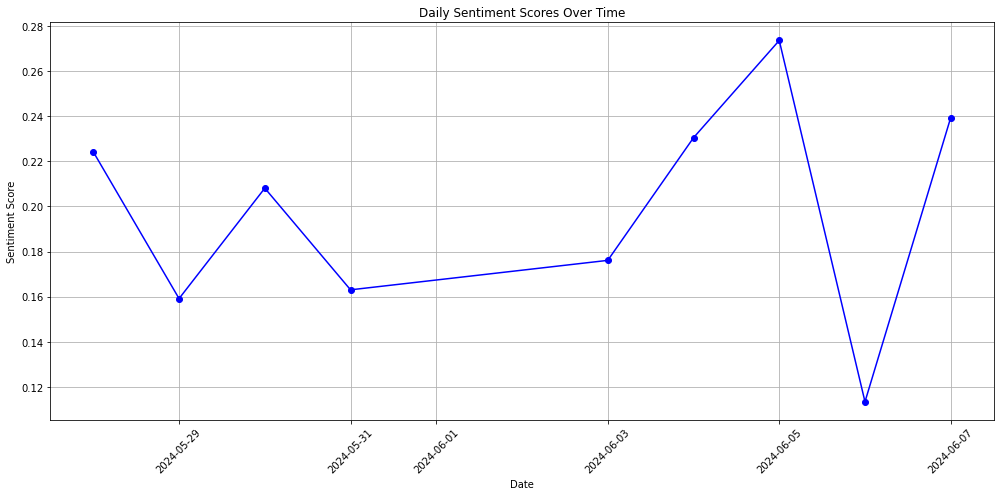

In [7]:
#Plotting the sentiment over time

plt.figure(figsize=(14, 7))
plt.plot(daily_combined_data['day'], daily_combined_data['sentiment'], marker='o', linestyle='-', color='b')
plt.title('Daily Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


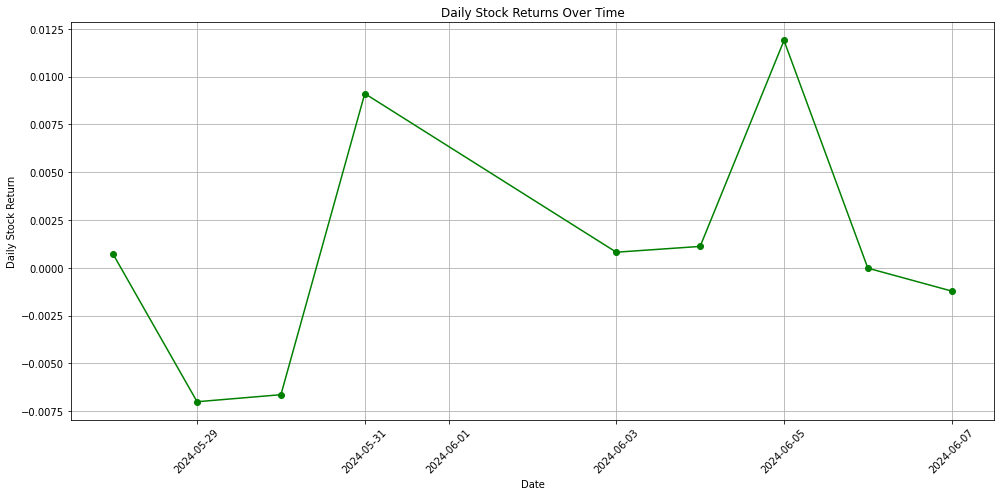

In [8]:
# Stock performance over time
plt.figure(figsize=(14, 7))
plt.plot(daily_combined_data['day'], daily_combined_data['daily_return'], marker='o', linestyle='-', color='g')
plt.title('Daily Stock Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Stock Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


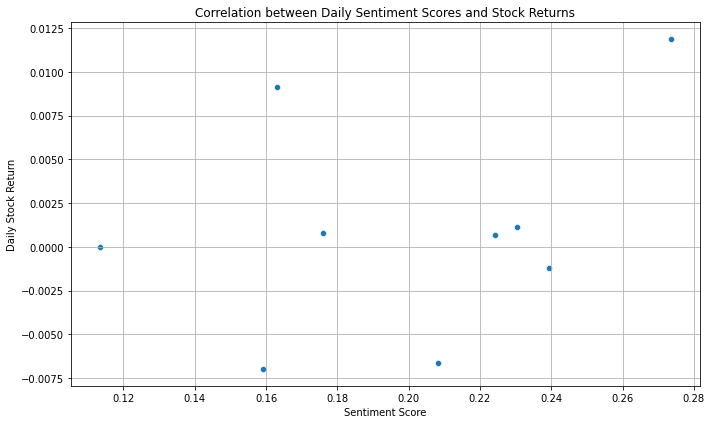

In [9]:
# Correlation scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment', y='daily_return', data=daily_combined_data)
plt.title('Correlation between Daily Sentiment Scores and Stock Returns')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Stock Return')
plt.grid(True)
plt.tight_layout()
plt.show()

The moderate positive correlation of .31 shows that the market sentiment captured from news article as a noticeable impact on stock performance when analyzing daily sentiment scores and daily stock returns!